In [8]:
import scipy.io as sio
import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import time
from tensorflow.contrib.slim import fully_connected as fc
from tensorflow.python.ops.parallel_for.gradients import jacobian

from mpl_toolkits.mplot3d import Axes3D
from vtk.util import numpy_support
import vtk
import gc
import h5py

import random

In [ ]:
filepath = 'train.mat'
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)

In [ ]:
train = arrays["train"]
print(train.shape)

In [ ]:
test = sio.loadmat('test.mat')
test = np.array(test["test"]).transpose()
np.save('train.npy',train)
np.save('test.npy',test)

In [ ]:
test01 = test/(-9)
train01 = train/(-9)
np.save('train01.npy',train01)
np.save('test01.npy',test01)

In [9]:
test = np.load('test01.npy')
train = np.load('train01.npy')

In [10]:
test16 = np.zeros((16,192000))
for i in range(8):
    test16[i*2:(i+1)*2] = test[i*100+2:(i*100+4)]

In [11]:
def plotfigures3D(x,nrows,ncols,ra,layer):  
    fig, axes = plt.subplots(nrows, ncols,figsize = (ncols*ra*3, nrows*ra))
    axesf = axes.flatten()
    for i in range(ncols*nrows):

        ax1 = axesf[i]
        image = np.reshape(x[i],(40,120,40))
        ax1.imshow(image[:,:,layer],cmap='jet')
        #ax1.imshow(x[i].reshape(100,100),cmap='gray_r')

        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)
    plt.show()

In [17]:
def test_reconstruction(model, test,layer):
    recon = model.reconstructor(test)
    plotfigures3D(test*(-9),8,2,1,layer)
    plotfigures3D(recon*(-9),8,2,1,layer)

In [14]:
class VAE(object):

    def __init__(self, n_z=35, conv1n=4, wrecon=1, wlatent=1, l2c = 0):
        self.conv1n = conv1n
        self.n_z = n_z
        self.l2c = l2c
        self.wrecon = wrecon
        self.wlatent = wlatent
        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])
        self.learning_rate = tf.placeholder(name = 'learning_rate',dtype = tf.float64,shape = None)
        self.is_training = tf.placeholder(name = 'is_training',dtype = tf.bool,shape = None)
        inp = tf.reshape(self.x,[-1,40,120,40,1])
        
        conv1 = tf.contrib.layers.conv3d(inp,self.conv1n,3,stride=2,
                                 padding='SAME',activation_fn=tf.nn.relu, scope = 'conv1')
        print(conv1.shape)
        conv2 = tf.contrib.layers.conv3d(conv1,self.conv1n*2,3,stride=2,
                                 padding='SAME',activation_fn=tf.nn.relu, scope = 'conv2')
        print(conv2.shape)
        conv3 = tf.contrib.layers.conv3d(conv2,self.conv1n*4,3,stride=2,
                                 padding='same',activation_fn=tf.nn.relu, scope = 'conv3')
        print(conv3.shape)
        conv4 = tf.contrib.layers.conv3d(conv3,self.conv1n*8,3,stride=2,
                                 padding='valid',activation_fn=tf.nn.relu, scope = 'conv4')
        print(conv4.shape)
        f0 = tf.reshape(conv4,[-1,2*7*2*8*self.conv1n])
        #f1 =fc(f0, 100, scope='fc1',activation_fn=tf.nn.relu)
        
        self.z_mu = fc(f0, self.n_z, scope='enc_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f0, self.n_z, scope='enc_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        dfc1 = fc(self.z, 2*7*2*8*self.conv1n, scope='dfc1',activation_fn=tf.nn.relu)
        #dfc2 = fc(dfc1, 6*6*10, scope='dfc2',activation_fn=tf.nn.relu)
        inp = tf.reshape(dfc1,[-1,2,7,2,64])
        print(inp.shape)
        dconv1 = tf.layers.conv3d_transpose(inp,self.conv1n*4,3,2,"valid",activation=tf.nn.relu, name= 'dconv1')
        print(dconv1.shape)
        
        dconv2 = tf.layers.conv3d_transpose(dconv1,self.conv1n*2,3,2,"same", activation=tf.nn.relu, name = 'dconv2')
        print(dconv2.shape)
        
        
        dconv3 = tf.layers.conv3d_transpose(dconv2,self.conv1n,3,2,"SAME",  activation=tf.nn.relu, name = 'dconv3')
        print(dconv3.shape)
        
        dconv4 = tf.layers.conv3d_transpose(dconv3,1,3,2,"SAME",activation=tf.nn.sigmoid, name = 'dconv4')
        print(dconv4.shape)
        
        self.x_hat = tf.reshape(dconv4,[-1,192000])
        epsilon = 1e-5
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        
        self.recon_loss = tf.reduce_mean(recon_loss)
        self.l2w = sum(tf.nn.l2_loss(var) for var in tf.trainable_variables() if not 'biases' in var.name)
        self.l2b = sum(tf.nn.l2_loss(var) for var in tf.trainable_variables() if not 'weights' in var.name)
        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = self.n_z*tf.reduce_mean(latent_loss)

        self.total_loss = self.wrecon*self.recon_loss + self.wlatent*self.latent_loss + self.l2c*(self.l2w+self.l2b)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
            'l2': self.l2w
        }        
        return

    def run_single_step(self, x,learning_rate):
        is_training = True
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x, self.learning_rate:learning_rate,self.is_training : is_training}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        is_training = False
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x,self.is_training : is_training})
        return x_hat

    # z -> x
    def generator(self, z):
        is_training = False
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z,self.is_training : is_training})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        is_training = False
        z = self.sess.run(self.z, feed_dict={self.x: x,self.is_training : is_training})
        return z
    def caljacob(self,z):
        is_training = False
        jacob = self.sess.run(jacobian(self.x_hat,self.z), feed_dict={self.z:z,self.is_training : is_training})
        return jacob
    def calgrad(self,z,wellloc):
        is_training = False
        gradient = self.sess.run([tf.gradients(self.x_hat[:,n-1],(self.z))[0] for n in wellloc], feed_dict={self.z:z,self.is_training : is_training})
        return gradient

In [15]:
def trainer(
    model_object, 
    learning_rate=1e-4, batch_size=64, 
    num_epochs=100, n_z=50, log_step=10,savename = "tf_models/VAE.ckpt",l2c = 0,
    train0 = train, conv1n=4, wrecon=1, wlatent=1):
    model = model_object(
        n_z = n_z, conv1n = conv1n, wrecon = wrecon, wlatent = wlatent, l2c = l2c
    )
    train = np.array(train0)
    for epoch in range(num_epochs):
        start_time = time.time()
        np.random.shuffle(train)
        for iter in range(num_sample // batch_size):
            batch = train[iter*batch_size:(iter+1)*batch_size]
            losses = model.run_single_step(batch,learning_rate)
        end_time = time.time()
        if epoch % log_step == 0:
            log_str = '[Epoch: {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}'.format(k, v)
                log_str += '({:.3f}sec/epoch)'.format(end_time - start_time)
            print(log_str)
        if epoch % 10== 0:
            learning_rate = learning_rate*0.95
            test_reconstruction(model, test16,39)
    saver = tf.train.Saver()
    model_path = saver.save(model.sess, savename)
    test_reconstruction(model, test16,39)
    print("Model saved in %s" % model_path)
    print('Done')
    return model

In [ ]:
num_sample = 3200
input_dim = 192000
model = trainer(VAE, conv1n=8, wrecon=1, wlatent=1,
                num_epochs=500, learning_rate=1e-3, 
                batch_size=100,l2c = 0.05,n_z=32, train0 = train, savename = "tf_models/VAE32.ckpt")

In [16]:
input_dim = 192000
model = VAE(n_z = 32, conv1n = 8, wrecon = 1, wlatent = 1, l2c = 0.05)
saver = tf.train.Saver()
saver.restore(model.sess, "tf_models/VAE32.ckpt")

Instructions for updating:
Colocations handled automatically by placer.
(?, 20, 60, 20, 8)
(?, 10, 30, 10, 16)
(?, 5, 15, 5, 32)
(?, 2, 7, 2, 64)
(?, 2, 7, 2, 64)
Instructions for updating:
Use keras.layers.conv3d_transpose instead.
(?, 5, 15, 5, 32)
(?, 10, 30, 10, 16)
(?, 20, 60, 20, 8)
(?, 40, 120, 40, 1)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tf_models/VAE32.ckpt


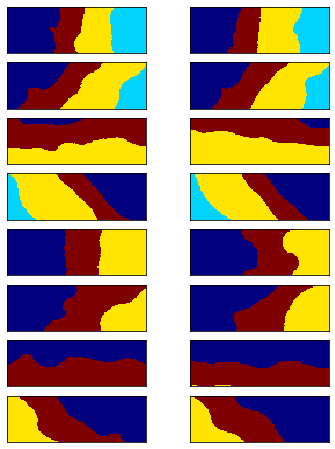

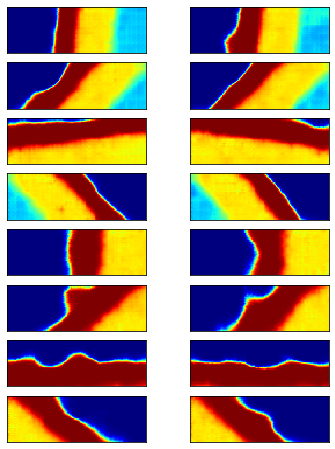

In [18]:
test_reconstruction(model, test16,35)

In [41]:
def test_transformation(model,batch=train):
    # Test the trained model: transformation
    z = model.transformer(batch)
    print(z.shape)
    plt.figure(figsize=(10, 8)) 
    plt.scatter(z[:, 0], z[:, 1],s=30,color = 'black')

(800, 32)


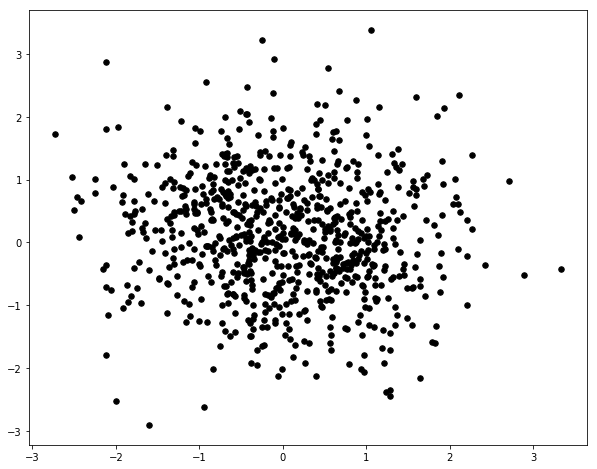

In [42]:
test_transformation(model,test)